In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column,row
output_notebook(hide_banner=True)
import cartopy.crs as ccrs
import cartopy

from scipy.stats import t,linregress,pearsonr

from precip_model_functions import *
#from smith_lm import full_linear_model_saturated

# O'Gorman & Schneider precip model
$-\left\{\omega\left.\dfrac{dq_s}{dp}\right|_{\theta_e}\right\}$

In [8]:
#/!\/!\/!\/!\/!\ Check time discretization
ct = "ghats"
ds = p99_era5[ct][49:]
lonlat = box[ct]["small"]

ti=time.time()
for d in ds :
    #if os.path.isfile("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesbmsinXqinteg.plev8_1.%s.%s.nc"%(d,ct)):
    #    print("Already done !")
    #    continue

    t=time.time()
    pr = precip_model_OGorman([d],lonlat,[1,4,6,8])
    pr[0].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaERA5Xqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[1].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesinXqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[2].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopeblqesinXqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[3].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesbmsinXqinteg.plev8_1.%s.%s.nc"%(d,ct))

    print("Done ",d,(time.time()-t)/60)


print("Total time : %i min"%((time.time()-ti)/60))


elapsed time / temperature, sfc pressure :  6.3233325481414795
elapsed time / upslope omega :  11.033860206604004
elapsed time / ERA5 omega :  5.374766111373901
elapsed time / ub,vb and 2m temperature :  1.3728442192077637
elapsed time / specific humidity :  4.757862329483032
elapsed time / geopotential height :  4.794531345367432
elapsed time / specific humidity and 2m temperature:  4.831162691116333
Done  19920716 1.75865851243337
elapsed time / temperature, sfc pressure :  5.757647275924683
elapsed time / upslope omega :  11.014222145080566
elapsed time / ERA5 omega :  5.647323369979858
elapsed time / ub,vb and 2m temperature :  1.1049213409423828
elapsed time / specific humidity :  5.291784763336182
elapsed time / geopotential height :  5.349183559417725
elapsed time / specific humidity and 2m temperature:  5.403973579406738
Done  19940602 1.7688320477803547
elapsed time / temperature, sfc pressure :  5.275846481323242
elapsed time / upslope omega :  11.105814218521118
elapsed time

In [9]:
#/!\/!\/!\/!\/!\ Check time discretization
ct = "vietnam"
ds = p99_era5[ct][49:]
lonlat = box[ct]["small"]

ti=time.time()
for d in ds :
    #if os.path.isfile("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesbmsinXqinteg.plev8_1.%s.%s.nc"%(d,ct)):
    #    print("Already done !")
    #    continue

    t=time.time()
    pr = precip_model_OGorman([d],lonlat,[1,4,6,8])
    pr[0].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaERA5Xqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[1].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesinXqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[2].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopeblqesinXqinteg.plev8_1.%s.%s.nc"%(d,ct))
    pr[3].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesbmsinXqinteg.plev8_1.%s.%s.nc"%(d,ct))

    print("Done ",d,(time.time()-t)/60)


print("Total time : %i min"%((time.time()-ti)/60))


elapsed time / temperature, sfc pressure :  5.813387870788574
elapsed time / upslope omega :  11.599519968032837
elapsed time / ERA5 omega :  5.467999219894409
elapsed time / ub,vb and 2m temperature :  1.1978251934051514
elapsed time / specific humidity :  5.258466005325317
elapsed time / geopotential height :  5.285409927368164
elapsed time / specific humidity and 2m temperature:  4.9452879428863525
Done  19901115 2.0107149998346965
elapsed time / temperature, sfc pressure :  5.283009767532349
elapsed time / upslope omega :  10.64207649230957
elapsed time / ERA5 omega :  5.323549032211304
elapsed time / ub,vb and 2m temperature :  1.3478779792785645
elapsed time / specific humidity :  4.887802600860596
elapsed time / geopotential height :  4.701022624969482
elapsed time / specific humidity and 2m temperature:  4.575726747512817
Done  19910316 1.8502954602241517
elapsed time / temperature, sfc pressure :  5.265325307846069
elapsed time / upslope omega :  12.612416982650757
elapsed tim

## Model with ERA5 omega vs model with upslope omega vs TRMM

In [3]:
def plot_precips(days,pr,ctname):
    assert len(pr)>=6
    flag=0
    pr_era5_og       = pr[0]
    pr_upsmean_og    = pr[1]
    pr_upssin_og     = pr[2]
    pr_upsblqesin_og = pr[3]
    pr_trmm          = pr[-2]
    pr_era5          = pr[-1]
    if len(pr)==7:
        flag=1
        pr_upsblqe2sin_og = pr[4]
        
    m=np.max(pr)
        
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
    ax1.plot(days,np.array(pr_trmm),label="TRMM",color="green")
    ax1.plot(days,np.array(pr_era5),label="ERA5",color="magenta")
    ax1.plot(days,np.array(pr_era5_og)   ,label="O'Gorman w/ ERA5 omega")
    #ax1.plot(days,np.array(pr_upsmean_og)   ,label="O'Gorman w/ cst. upslope omega")
    ax1.plot(days,np.array(pr_upssin_og)   ,label="O'Gorman w/ sin upslope omega",color="k")
    ax1.plot(days,np.array(pr_upsblqesin_og)   ,label="O'Gorman w/ sin upslope+convective omega",color="gold")
    if flag:
        ax1.plot(days,np.array(pr_upsblqe2sin_og)   ,label="O'Gorman w/ sin upslope+convective omega (1% of clouds)",color="y")
    ax1.set_xlabel("date")
    ax1.set_ylabel("event precip (mm)")
    
    
    ax2.scatter(np.array(pr_era5),np.array(pr_era5_og)   ,        label="O'Gorman w/ ERA5 omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_era5_og   )[0,1],rsquared(pr_era5,pr_era5_og   )))
    #ax2.scatter(np.array(pr_era5),np.array(pr_upsmean_og),label="O'Gorman w/ cst. upslope omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsmean_og)[0,1],rsquared(pr_era5,pr_upsmean_og)))
    ax2.scatter(np.array(pr_era5),np.array(pr_upssin_og) , label="O'Gorman w/ sin upslope omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upssin_og )[0,1],rsquared(pr_era5,pr_upssin_og )),color="k")
    ax2.scatter(np.array(pr_era5),np.array(pr_upsblqesin_og),label="O'Gorman w/ sin upslope+convective omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsblqesin_og)[0,1],rsquared(pr_era5,pr_upsblqesin_og)),color="gold")
    if flag:
        ax2.scatter(np.array(pr_era5),np.array(pr_upsblqe2sin_og),label="O'Gorman w/ sin upslope+convective omega (1%% of clouds), r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsblqe2sin_og)[0,1],rsquared(pr_era5,pr_upsblqe2sin_og)),color="y")
    ax2.plot(np.array(pr_era5),np.array(pr_era5),color="magenta",label="ERA5 (1 to 1 line)")
    ax2.set_xlabel("ERA5 event precip (mm)")
    ax2.set_ylabel("model event precip (mm)")
    
    
    ax1.legend()
    ax2.legend()
    ax1.set_ylim(0,m)
    ax2.set_xlim(0,m)
    ax2.set_ylim(0,m)
    
    fig.suptitle(ctname+" rx5",fontsize=20)
    return ax1,ax2

In [16]:
def plot_precips_bokeh(days,prdict,ctname): 
    m=np.max(np.array([v[0] for v in prdict.values()]))   

    fig_sc = figure(plot_height=300, plot_width=550,
                    title = "Scatter plot of 99th pctile events total precipitation (mm), models vs ERA5 precip, %s rx5"%ctname,
                    x_axis_label='ERA5 event precip (mm)',
                    y_axis_label='model event precip (mm)',
                    y_range=(0,m))

    ref = list(prdict.keys())[0]
    prref = np.array(prdict[ref][0])
    fig_sc.line(prref,prref,line_width=2,legend_label="%s (1 to 1 line)"%ref,color=prdict[ref][1])
    for k in prdict.keys():
        prk,colork = prdict[k]
        prk = np.array(prk)
        fig_sc.scatter(prref,prk,line_width=2,legend_label="%s, r=%.2f, R^2=%.2f"%(k,np.corrcoef(prref,prk)[0,1],rsquared(prref,prk)),color=colork)

    fig_sc.legend.click_policy="hide"
    fig_sc.legend.label_text_font_size = "7pt";  fig_sc.legend.glyph_height = 10; fig_sc.legend.label_height=10
    fig_sc.legend.padding= 0;fig_sc.legend.spacing=0; fig_sc.legend.background_fill_alpha = 0.4
    
    fig_sc.legend.location="bottom_right"
    
    return fig_sc

def quickplot(ct):
    i1998 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=1998][0]
    i2014 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=2014][0]
    p99_era5_2 = p99_era5[ct][i1998:i2014]
    pr = retrieve_modeled_precip("p99",p99_era5[ct][49:],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_1","omegaupslopesinXqinteg.plev8_1"],0,0,1)

    prtrmm = retrieve_modeled_precip("p99",p99_era5_2,box[ct]["small"],ct,[],1,0,0)[0]

    prdict = {"ERA5":(pr[-1],"magenta"),
              "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
              "O'Gorman + upslope omega ":(pr[1],"black"),
              #"O'Gorman + upslope/BLQE omega ":(pr[2],"gold"),
              #"Smith linear model ":(pr[3],"purple")
             }
    fig_sc=plot_precips_bokeh(p99_era5_datetime[ct][49:],prdict,names[ct])
    #fig_sc.scatter(np.array(pr[-1][i1998:i2014]),np.array(prtrmm),line_width=2,color="green",legend_label="trmm" )
    return pr,fig_sc
    

In [4]:
prnep,fig_sc = quickplot("Candes")
show(fig_sc)

In [17]:
prnep,fig_sc = quickplot("vietnam")
show(fig_sc)

In [18]:
prnep,fig_sc = quickplot("ghats")
show(fig_sc)

prnep,fig_sc = quickplot("california")
show(fig_sc)

In [26]:
ct = "Candes"
prCan= retrieve_modeled_precip("p99",p99_era5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_1","omegaupslopesinXqinteg.plev8_1","omegaupslopeblqesinXqinteg.plev8_1","omegaupslopesbmsinXqinteg.plev8_1","smith"],0,0,1)
        

In [27]:
ct = "Candes"
pr=prCan
prdict = {"ERA5":(pr[-1],"magenta"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega ":(pr[1],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[2],"gold"),
          "O'Gorman + upslope/SBM omega ":(pr[3],"pink"),
          "Smith linear model ":(pr[4],"purple")
         }
fig_sc = plot_precips_bokeh(p99_era5_datetime[ct],prdict,names[ct])
show(fig_sc)

In [13]:
ct = "Sandes"
prSan= retrieve_modeled_precip("p99",p99_era5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_1","omegaupslopesinXqinteg.plev8_1","smith"],0,0,1)
i1998 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=1998][0]
i2014 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=2014][0]
p99_era5_2 = p99_era5[ct][i1998:i2014]
prtrmm_San = retrieve_modeled_precip("p99",p99_era5_2,box[ct]["small"],ct,[],1,0,0)[0]


In [14]:
prSan2 = retrieve_modeled_precip("p99",p99_era5[ct][-40:],box[ct]["small"],ct,["omegaERA5Xqinteg.dt1.plev8_1","omegaupslopesinXqinteg.dt1.plev8_1"],0,0,0)

                                                                               

In [15]:
ct = "Sandes"
pr=prSan
prdict = {"ERA5":(pr[-1][-40:],"magenta"),
          "O'Gorman + ERA5 omega ":(pr[0][-40:],"dodgerblue"),
          "O'Gorman + upslope omega ":(pr[1][-40:],"black"),
          "O'Gorman + ERA5 dt=1h ":(prSan2[0],"blue"),
          "O'Gorman + upslope dt=1h ":(prSan2[1],"grey")}
        #  "O'Gorman + upslope/BLQE omega ":(pr[2],"gold")
        # }
fig_sc = plot_precips_bokeh(p99_era5_datetime[ct],prdict,names[ct])
#fig_sc.scatter(np.array(prSan[-1][i1998:i2014]),np.array(prtrmm_San),line_width=2,color="green",legend_label="trmm" )

prdict2 = {"ERA5":(pr[-1],"magenta"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega ":(pr[1],"black"),
          "Smith Linear model ":(pr[2],"purple")
         }
fig_sc2 = plot_precips_bokeh(p99_era5_datetime[ct],prdict2,names[ct])
fig_sc2.scatter(np.array(prSan[-1][i1998:i2014]),np.array(prtrmm_San),line_width=2,color="green",legend_label="trmm" )


show(row(fig_sc2,fig_sc))

In [11]:
ct = "california"
#p99_era5[ct].remove("20101024")
#p99_era5_datetime[ct].remove(pd.to_datetime("20101024", format='%Y%m%d'))
prcal= retrieve_modeled_precip("p99",p99_era5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_1","omegaupslopesinXqinteg.plev8_1","smith"],0,0,1)
i1998 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=1998][0]
i2014 = [i for i in range(len(p99_era5[ct])) if int(p99_era5[ct][i][:4])>=2014][0]
p99_era5_2 = p99_era5[ct][i1998:i2014]

prtrmm_cal = retrieve_modeled_precip("p99",p99_era5_2,box[ct]["small"],ct,[],1,0,0)[0]

In [12]:
ct = "california"
pr=prcal
prdict = {"ERA5":(pr[-1],"magenta"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega ":(pr[1],"black"),
          "Smith Linear model ":(pr[2],"purple")
         }


fig_sc=plot_precips_bokeh(p99_era5_datetime[ct],prdict,names[ct])
fig_sc.scatter(np.array(prcal[-1][i1998:i2014]),np.array(prtrmm_cal),line_width=2,color="green",legend_label="trmm" )

show(fig_sc)

## Spatial Correlations

In [43]:
def precip_space_correlations(ds,lonlat,ct):
    corrsera5=[]
    corrsupslope=[]
    corrssmith=[]
    for j in range(len(ds)) :
        d=ds[j]
        pr_ogera5 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaERA5Xqinteg.plev8_1.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_ogupslope = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesinXqinteg.plev8_1.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_smith = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.smith.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_era5 = precipERA51d(d,lonlat)
        
        pr_smith2 = pr_smith.isel(longitude=range(1,41))
        pr_era52 = pr_era5.isel(longitude=range(1,41))
        
        corrsera5.append(np.corrcoef(np.reshape(np.array(pr_era5),-1),np.reshape(np.array(pr_ogera5),-1))[1,0])
        corrsupslope.append(np.corrcoef(np.reshape(np.array(pr_era5),-1),np.reshape(np.array(pr_ogupslope),-1))[1,0])
        corrssmith.append(np.corrcoef(np.reshape(np.array(pr_era52),-1),np.reshape(np.array(pr_smith2),-1))[1,0])
    return np.array(corrsera5),np.array(corrsupslope),np.array(corrssmith)

def correlation_of_means(ds,lonlat,ct):
    corrsera5   =[]
    corrsupslope=[]
    corrssmith  =[]
    pr_ogera5   =0
    pr_ogupslope=0
    pr_smith    =0
    pr_era5     =0
    for j in range(len(ds)) :
        d=ds[j]
        pr_ogera5   += xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaERA5Xqinteg.plev8_1.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_ogupslope+= xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.omegaupslopesinXqinteg.plev8_1.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_smith    += xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.smith.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
        pr_era5     += precipERA51d(d,lonlat)
    pr_ogera5   /=len(ds)
    pr_ogupslope/=len(ds)
    pr_smith    /=len(ds)
    pr_era5     /=len(ds)
    
    print("Correlation of means, pog era5 :",   np.corrcoef(np.reshape(np.array(pr_era5),-1),np.reshape(np.array(pr_ogera5   ),-1))[1,0])
    print("Correlation of means, pog upslope :",np.corrcoef(np.reshape(np.array(pr_era5),-1),np.reshape(np.array(pr_ogupslope),-1))[1,0])
    print("Correlation of means, smith :",      np.corrcoef(np.reshape(np.array(pr_era5),-1),np.reshape(np.array(pr_smith    ),-1))[1,0])

    return pr_ogera5,pr_ogupslope,pr_smith,pr_era5

In [4]:
ct = "california"
p999_era5_cal = ['19790111', '19860217', '19950109', '19950110', '19950309', '19951212', '19970101', '20021216', '20041208', '20051231', '20080104', '20101024', '20121130', '20121202', '20141211']
corrsera5,corrsupslope,corrssmith = precip_space_correlations(p99_era5[ct],box[ct]["small"],ct)
print(np.mean(corrsera5)   ,np.std(corrsera5)   )
print(np.mean(corrsupslope),np.std(corrsupslope))
print(np.mean(corrssmith),np.std(corrssmith))
pr_ogera5,pr_ogupslope,pr_smith,pr_era5 = correlation_of_means(p99_era5[ct],box[ct]["small"],ct)

0.6102221264847774 0.11293751928991494
0.5983123681224644 0.17439962681043872
0.4897289968499768 0.22939813135157383
Correlation of means, pog era5 : 0.616065108701972
Correlation of means, pog upslope : 0.7108045411432448
Correlation of means, smith : 0.7044392696635698


Text(0.5,1,'Smith, mean = 24.1 mm/day')

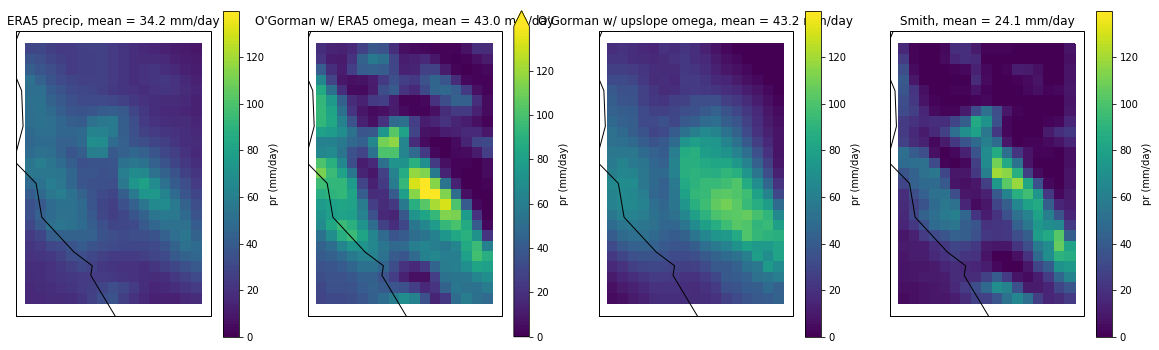

In [5]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})
pr_era5.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogera5.plot(   ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogupslope.plot(ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_smith.plot(    ax=ax4,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("ERA5 precip, mean = %.1f mm/day"%np.mean(np.array(pr_era5)))
ax2.set_title("O'Gorman w/ ERA5 omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogera5)))
ax3.set_title("O'Gorman w/ upslope omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogupslope)))
ax4.set_title("Smith, mean = %.1f mm/day"%np.mean(np.array(pr_smith)))


In [41]:
ct = "Sandes"
corrsera5,corrsupslope,corrssmith = precip_space_correlations(p99_era5[ct],box[ct]["small"],ct)
print(np.mean(corrsera5)   ,np.std(corrsera5)   )
print(np.mean(corrsupslope),np.std(corrsupslope))
print(np.mean(corrssmith),np.std(corrssmith))
pr_ogera5,pr_ogupslope,pr_smith,pr_era5 = correlation_of_means(p99_era5[ct],box[ct]["small"],ct)

0.656740705123159 0.09256049786140189
0.6263884106485476 0.12447106475756767
0.38230843402192827 0.20520396848375833
Correlation of means, pog era5 : 0.6285128456888631
Correlation of means, pog upslope : 0.7630936397624947
Correlation of means, smith : 0.3367981446867834


In [10]:
pr_smith2 = pr_smith.isel(latitude=range(2,49))
pr_era52 = pr_era5.isel(latitude=range(2,49))
print("Correlation of means, smith :",      np.corrcoef(np.reshape(np.array(pr_era52),-1),np.reshape(np.array(pr_smith2    ),-1))[1,0])


Correlation of means, smith : 0.6028147508917657


Text(0.5,1,'Smith, mean = 21.5 mm/day')

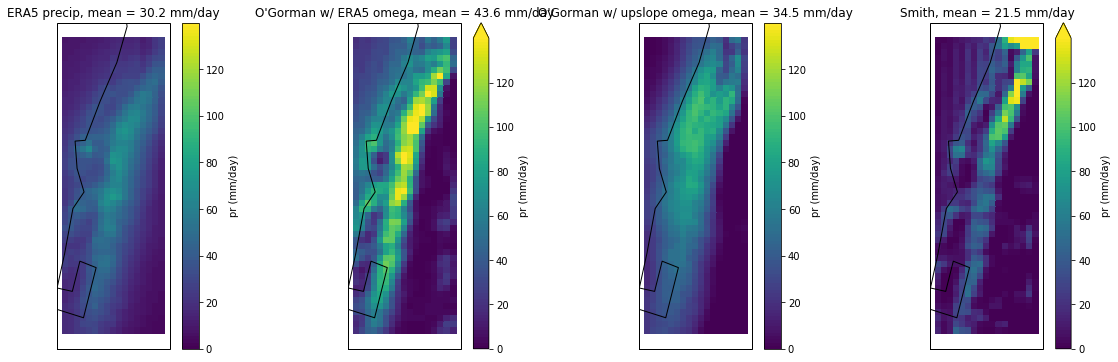

In [7]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})
pr_era5.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogera5.plot(   ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogupslope.plot(ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_smith.plot(    ax=ax4,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("ERA5 precip, mean = %.1f mm/day"%np.mean(np.array(pr_era5)))
ax2.set_title("O'Gorman w/ ERA5 omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogera5)))
ax3.set_title("O'Gorman w/ upslope omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogupslope)))
ax4.set_title("Smith, mean = %.1f mm/day"%np.mean(np.array(pr_smith)))


In [39]:
ct = "nepal"
corrsera5,corrsupslope,corrssmith = precip_space_correlations(p99_era5[ct],box[ct]["small"],ct)
print(np.mean(corrsera5)   ,np.std(corrsera5)   )
print(np.mean(corrsupslope),np.std(corrsupslope))
print(np.mean(corrssmith),np.std(corrssmith))
pr_ogera5,pr_ogupslope,pr_smith,pr_era5 = correlation_of_means(p99_era5[ct],box[ct]["small"],ct)

0.8612518544546957 0.05582930764811877
0.3857840979080546 0.21354979070155608
0.3577874342607081 0.2080050956266519
Correlation of means, pog era5 : 0.9632424857062949
Correlation of means, pog upslope : 0.6682748424010907
Correlation of means, smith : 0.7687365446636212


In [32]:
pr_smith2 = pr_smith.isel(longitude=range(2,40))
pr_era52 = pr_era5.isel(longitude=range(2,40))
print("Correlation of means, smith :",      np.corrcoef(np.reshape(np.array(pr_era52),-1),np.reshape(np.array(pr_smith2    ),-1))[1,0])


Correlation of means, smith : 0.8182646771721057


Text(0.5,1,'Smith, mean = 25.1 mm/day')

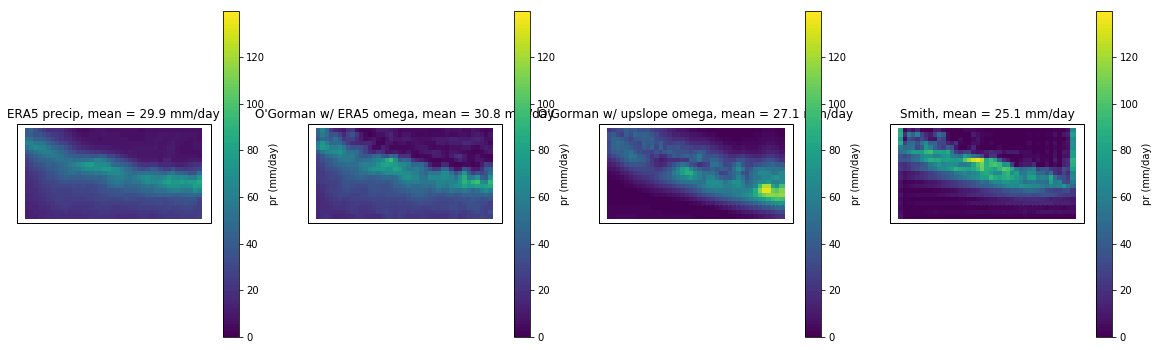

In [18]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})
pr_era5.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogera5.plot(   ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogupslope.plot(ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_smith.plot(    ax=ax4,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("ERA5 precip, mean = %.1f mm/day"%np.mean(np.array(pr_era5)))
ax2.set_title("O'Gorman w/ ERA5 omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogera5)))
ax3.set_title("O'Gorman w/ upslope omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogupslope)))
ax4.set_title("Smith, mean = %.1f mm/day"%np.mean(np.array(pr_smith)))


In [44]:
ct = "Candes"
corrsera5,corrsupslope,corrssmith = precip_space_correlations(p99_era5[ct],box[ct]["small"],ct)
print(np.mean(corrsera5)   ,np.std(corrsera5)   )
print(np.mean(corrsupslope),np.std(corrsupslope))
print(np.mean(corrssmith),np.std(corrssmith))
pr_ogera5,pr_ogupslope,pr_smith,pr_era5 = correlation_of_means(p99_era5[ct],box[ct]["small"],ct)

0.8240870030883094 0.06529560225602755
0.29288607866318744 0.2096746169478421
0.16108289543935997 0.23901216346005422
Correlation of means, pog era5 : 0.9700601636326708
Correlation of means, pog upslope : 0.45539412040575433
Correlation of means, smith : 0.10314881908133447


In [37]:
pr_smith2 = pr_smith.isel(longitude=range(1,41))
pr_era52 = pr_era5.isel(longitude=range(1,41))
print("Correlation of means, smith :",      np.corrcoef(np.reshape(np.array(pr_era52),-1),np.reshape(np.array(pr_smith2    ),-1))[1,0])


Correlation of means, smith : 0.39260842537138796


Text(0.5,1,'Smith, mean = 10.3 mm/day')

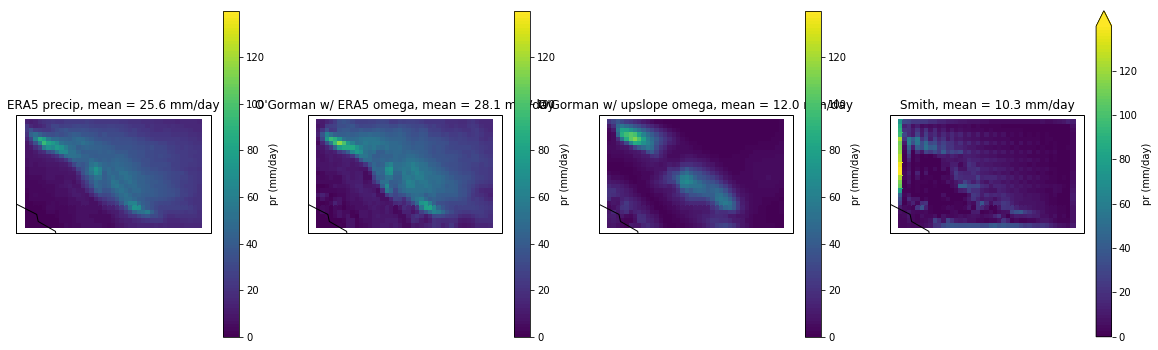

In [23]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})
pr_era5.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogera5.plot(   ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_ogupslope.plot(ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
pr_smith.plot(    ax=ax4,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,140.,20.)},levels=np.linspace(0.,140.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("ERA5 precip, mean = %.1f mm/day"%np.mean(np.array(pr_era5)))
ax2.set_title("O'Gorman w/ ERA5 omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogera5)))
ax3.set_title("O'Gorman w/ upslope omega, mean = %.1f mm/day"%np.mean(np.array(pr_ogupslope)))
ax4.set_title("Smith, mean = %.1f mm/day"%np.mean(np.array(pr_smith)))


## Running Smith's model

In [21]:
ct = "Candes"
ds = p99_era5[ct]
lonlat = box[ct]["small"]

ti=time.time()
for d in ds :
    t=time.time()
    pr = full_linear_model_saturated([d],lonlat)
    pr.to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/p99/pr/pr.smith.%s.%s.nc"%(d,ct))

    print("Done ",d,(time.time()-t))


print("Total time : %i min"%((time.time()-ti)/60))


Done  19791215 10.196806907653809
Done  19791222 9.388410091400146
Done  19791231 9.361710786819458
Done  19800112 9.504549741744995
Done  19800208 9.720081806182861
Done  19800213 9.496442317962646
Done  19801109 9.585986375808716
Done  19801130 9.40822720527649
Done  19801220 9.656155347824097
Done  19810114 9.576834201812744
Done  19810215 9.615225791931152
Done  19810317 9.411895990371704
Done  19811119 9.337402820587158
Done  19820122 9.326791286468506
Done  19820327 9.312532663345337
Done  19821104 9.348197937011719
Done  19821207 9.51351261138916
Done  19821223 9.270177602767944
Done  19830127 9.29633378982544
Done  19830201 9.277575254440308
Done  19830213 8.98570466041565
Done  19830310 9.201725721359253
Done  19831023 9.08876371383667
Done  19831122 9.174042463302612
Done  19831231 9.041095733642578
Done  19850127 9.057326793670654
Done  19850801 9.009586572647095
Done  19851112 9.145400047302246
Done  19860105 9.059743404388428
Done  19860118 9.027531385421753
Done  19860119